<a href="https://colab.research.google.com/github/khushidubeyokok/AI-ML/blob/main/04_DeepLearning/05_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoders
A Variational Autoencoder is a type of generative model that learns to represent complex data distributions in a continuous latent space.

- Unlike traditional autoencoders, which encode inputs into fixed vectors, VAEs encode inputs as probability distributions, usually **Gaussian—characterized** by a mean (μ) and standard deviation (σ).
- This allows them to generate new, similar data by **sampling** from the latent space.
- The VAE has two main components: the **encoder**, which maps input data to the parameters(μ,σ) of the latent distribution, and the **decoder**, which reconstructs the input from a latent sample.
- The key idea is to model the underlying data distribution and enforce smoothness in the latent space so similar latent points produce similar outputs.
---
- Training VAEs involves optimizing a **loss function with two parts**.

      Loss = −ELBO = Reconstruction Loss + KL Divergence
 - The first part is the reconstruction loss, which ensures the decoder can accurately reconstruct the input from the sampled latent vector.
 - The second part is the Kullback–Leibler (KL) divergence, which regularizes the latent distribution to be close to a standard Gaussian, preventing overfitting and encouraging meaningful latent representations.
- The **reparameterization trick** is crucial here—it allows backpropagation through the stochastic sampling step by expressing the latent variable as $z = \mu + \sigma \cdot \epsilon$, where $\epsilon \sim \mathcal{N}(0,1)$.
- This combination of probabilistic encoding and regularized latent space makes VAEs powerful for tasks like image generation, interpolation, anomaly detection, and representation learning.

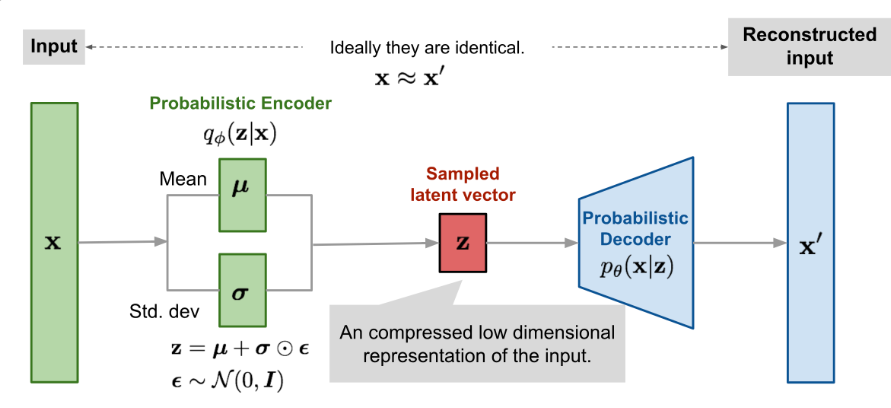

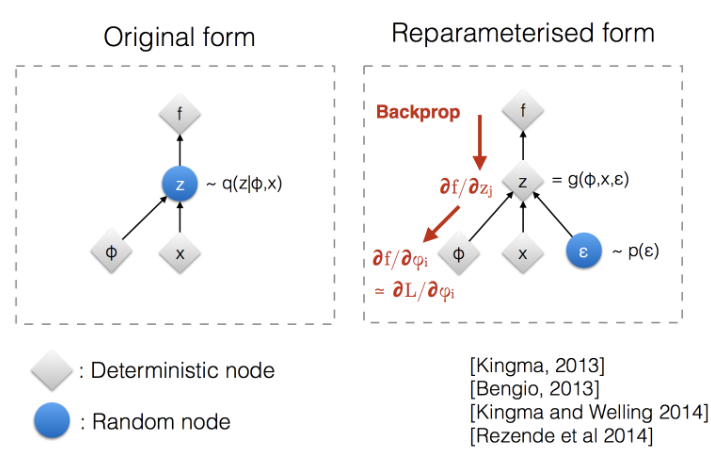



In [12]:
import torch
import torch.nn.functional as F
from torch import nn

Model architecture

In [13]:
# Input img(x) ->  hidden dim -> mean,std -> Reparameterization trick(z) -> decoder -> output img
class VAE(nn.Module):
  def __init__(self,input_dim,h_dim=200,z_dim=20):
    super().__init__()

    #encoder
    self.img_2hid=nn.Linear(input_dim,h_dim)
    self.hid_2mu=nn.Linear(h_dim,z_dim)
    self.hid_2sigma=nn.Linear(h_dim,z_dim)

    #decoder
    self.z_2hid=nn.Linear(z_dim,h_dim)
    self.hid_2img=nn.Linear(h_dim,input_dim)
    self.relu=nn.ReLU()

  def encode(self,x):
    h=self.relu(self.img_2hid(x))
    mu,sigma=self.hid_2mu(h),self.hid_2sigma(h)
    return mu,sigma

  def decode(self,z):
    h=self.relu(self.z_2hid(z))
    return torch.sigmoid(self.hid_2img(h))

  def forward(self,x):
    mu,sigma=self.encode(x)
    epsilon=torch.randn_like(sigma)
    z_reparam=mu+sigma*epsilon
    x_reconstructed=self.decode(z_reparam)
    return x_reconstructed,mu,sigma

In [14]:
x=torch.randn(4,28*28)
vae=VAE(input_dim=784)
x_reconstructed,mu,sigma=vae(x)
print(x_reconstructed.shape)
print(mu.shape)
print(sigma.shape)

torch.Size([4, 784])
torch.Size([4, 20])
torch.Size([4, 20])


Training loop

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
input_dim = 28*28
h_dim = 200
z_dim = 20
lr = 1e-3
batch_size = 128
epochs = 10

# Dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
vae = VAE(input_dim=input_dim, h_dim=h_dim, z_dim=z_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)

In [17]:
def vae_loss(x, x_reconstructed, mu, sigma):
    # Reconstruction loss (binary cross entropy)
    recon_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + torch.log(sigma**2 + 1e-8) - mu**2 - sigma**2)
    return recon_loss + kl_loss

In [18]:
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28)  # flatten
        optimizer.zero_grad()
        x_recon, mu, sigma = vae(data)
        loss = vae_loss(data, x_recon, mu, sigma)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader.dataset):.4f}")

Epoch 1/10, Loss: 187.8342
Epoch 2/10, Loss: 133.6521
Epoch 3/10, Loss: 122.6200
Epoch 4/10, Loss: 117.1755
Epoch 5/10, Loss: 114.1942
Epoch 6/10, Loss: 112.3675
Epoch 7/10, Loss: 111.0598
Epoch 8/10, Loss: 110.1559
Epoch 9/10, Loss: 109.4582
Epoch 10/10, Loss: 108.8831


Testing

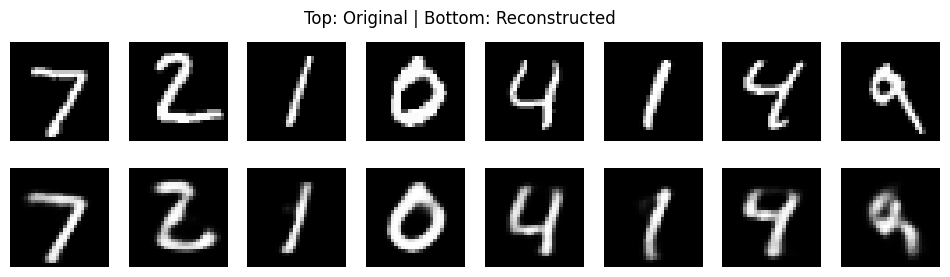

In [19]:
vae.eval()
test_batch = next(iter(test_loader))[0][:8].view(-1, 28*28)  # take 8 test images
with torch.no_grad():
    recon_batch, _, _ = vae(test_batch)

# Plot original vs reconstructed
fig, axes = plt.subplots(2, 8, figsize=(12,3))
for i in range(8):
    axes[0,i].imshow(test_batch[i].view(28,28), cmap='gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(recon_batch[i].view(28,28), cmap='gray')
    axes[1,i].axis('off')
plt.suptitle("Top: Original | Bottom: Reconstructed")
plt.show()

Generate new images by sampling new z

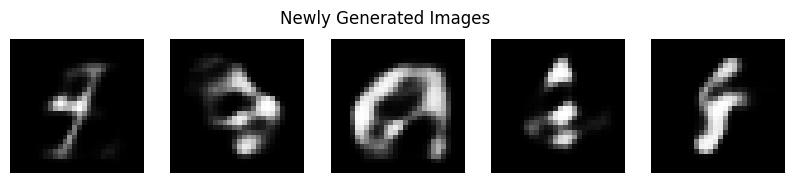

In [20]:
vae.eval()

# Sample new latent vectors from N(0,1)
num_samples = 5
z_new = torch.randn(num_samples, z_dim)

# Decode to generate new images
with torch.no_grad():
    generated_imgs = vae.decode(z_new)

# Visualize
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, num_samples, figsize=(10,2))
for i in range(num_samples):
    axes[i].imshow(generated_imgs[i].view(28,28), cmap='gray')
    axes[i].axis('off')
plt.suptitle("Newly Generated Images")
plt.show()

VAE outputs pixel probabilities hence the images are blurry, using a GAN (Generative Adversarial Networks) produces sharper images.